# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [1]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [2]:
bulkPath = '../nf_output/countData/countData.tsv'
metaPath = '../Brandão_SraRunTable.csv' # metadata from SRA
gffPath = '../nf_output/alignments/dualGenome.gff3' # output from nf pipeline

In [3]:
# Load data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
df_initial = df_initial.drop(columns=['SRR13160338_sorted.bam', 'SRR13160334_sorted.bam', 'SRR13160330_sorted.bam', 
                                      'SRR13160332_sorted.bam', 'SRR13160335_sorted.bam', 'SRR13160333_sorted.bam', 
                                      'SRR13160331_sorted.bam', 'SRR13160336_sorted.bam', 'SRR13160327_sorted.bam', 
                                      'SRR13160329_sorted.bam', 'SRR13160337_sorted.bam', 'SRR13160328_sorted.bam'])
metadata = pd.read_csv(metaPath)
metadata = metadata[metadata['medium'] == 'MCCM']

In [4]:
df_initial.head()

,Chr,Start,End,Strand,Length,SRR13160348_sorted.bam,SRR13160339_sorted.bam,SRR13160350_sorted.bam,SRR13160346_sorted.bam,SRR13160344_sorted.bam,SRR13160345_sorted.bam,SRR13160341_sorted.bam,SRR13160343_sorted.bam,SRR13160349_sorted.bam,SRR13160347_sorted.bam,SRR13160342_sorted.bam,SRR13160340_sorted.bam
Geneid,,,,,,,,,,,,,,,,,
gene-PA0001,NC_002516.2,483,2027,+,1545,144,710,353,165,545,144,328,844,76,58,627,758
gene-PA0002,NC_002516.2,2056,3159,+,1104,95,512,287,134,493,106,261,562,64,49,422,517
gene-PA0003,NC_002516.2,3169,4278,+,1110,109,581,256,224,550,140,384,822,78,74,490,768
gene-PA0004,NC_002516.2,4275,6695,+,2421,283,1622,468,486,1244,441,1086,2554,202,124,1805,1983
gene-PA0005,NC_002516.2,7018,7791,-,774,12,31,427,32,235,22,27,111,8,22,70,57


In [5]:
pd.set_option('display.max_columns', None)  # Show all columns
metadata

,Run,Assay Type,AvgSpotLen,Bacteria_Strain,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,medium,Organism,phage_moi,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,STAGE,treatment_time
12,SRR13160339,RNA-Seq,150,DSM22644,2016284115,PRJNA681237,SAMN16946595,782298417,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX9599326,GSM4948311,Illumina MiniSeq,PAIRED,cDNA,TRANSCRIPTOMIC,MCCM,Pseudomonas aeruginosa PAO1,phage wasn't added,ILLUMINA,2020-11-30T00:00:00Z,2020-11-28T01:17:00Z,1,GSM4948311,early exponential bacteria,SRP294562,early exponential,untreated
13,SRR13160340,RNA-Seq,150,DSM22644,1811804506,PRJNA681237,SAMN16946826,707901548,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX9599327,GSM4948312,Illumina MiniSeq,PAIRED,cDNA,TRANSCRIPTOMIC,MCCM,Pseudomonas aeruginosa PAO1,phage wasn't added,ILLUMINA,2020-11-30T00:00:00Z,2020-11-28T01:17:00Z,1,GSM4948312,early exponential bacteria,SRP294562,early exponential,untreated
14,SRR13160341,RNA-Seq,150,DSM22644,1958250437,PRJNA681237,SAMN16946825,762915390,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX9599321,GSM4948313,Illumina MiniSeq,PAIRED,cDNA,TRANSCRIPTOMIC,MCCM,Pseudomonas aeruginosa PAO1,phage wasn't added,ILLUMINA,2020-11-30T00:00:00Z,2020-11-28T01:16:00Z,1,GSM4948313,early exponential bacteria,SRP294562,early exponential,untreated
15,SRR13160342,RNA-Seq,150,DSM22644,1747437654,PRJNA681237,SAMN16946824,674935324,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX9599328,GSM4948314,Illumina MiniSeq,PAIRED,cDNA,TRANSCRIPTOMIC,MCCM,Pseudomonas aeruginosa PAO1,MOI=75,ILLUMINA,2020-11-30T00:00:00Z,2020-11-28T01:16:00Z,1,GSM4948314,early exponential 5 min infected with phage,SRP294562,early exponential,5 min with phage
16,SRR13160343,RNA-Seq,150,DSM22644,1911568917,PRJNA681237,SAMN16946823,744150652,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX9599329,GSM4948315,Illumina MiniSeq,PAIRED,cDNA,TRANSCRIPTOMIC,MCCM,Pseudomonas aeruginosa PAO1,MOI=75,ILLUMINA,2020-11-30T00:00:00Z,2020-11-28T01:17:00Z,1,GSM4948315,early exponential 5 min infected with phage,SRP294562,early exponential,5 min with phage
17,SRR13160344,RNA-Seq,149,DSM22644,1543889209,PRJNA681237,SAMN16946822,553931309,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX9599330,GSM4948316,Illumina MiniSeq,PAIRED,cDNA,TRANSCRIPTOMIC,MCCM,Pseudomonas aeruginosa PAO1,MOI=75,ILLUMINA,2020-11-30T00:00:00Z,2020-11-28T01:15:00Z,1,GSM4948316,early exponential 5 min infected with phage,SRP294562,early exponential,5 min with phage
18,SRR13160345,RNA-Seq,150,DSM22644,2140632663,PRJNA681237,SAMN16946821,825557233,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX9599331,GSM4948317,Illumina MiniSeq,PAIRED,cDNA,TRANSCRIPTOMIC,MCCM,Pseudomonas aeruginosa PAO1,MOI=75,ILLUMINA,2020-11-30T00:00:00Z,2020-11-28T01:17:00Z,1,GSM4948317,early exponential 10 min infected with phage,SRP294562,early exponential,10 min with phage
19,SRR13160346,RNA-Seq,150,DSM22644,1841074984,PRJNA681237,SAMN16946820,718680484,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX9599332,GSM4948318,Illumina MiniSeq,PAIRED,cDNA,TRANSCRIPTOMIC,MCCM,Pseudomonas aeruginosa PAO1,MOI=75,ILLUMINA,2020-11-30T00:00:00Z,2020-11-28T01:15:00Z,1,GSM4948318,early exponential 10 min infected with phage,SRP294562,early exponential,10 min with phage
20,SRR13160347,RNA-Seq,150,DSM22644,1887090304,PRJNA681237,SAMN16946819,678442733,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX9599333,GSM4948319,Illumina MiniSeq,PAIRED,cDNA,TRANSCRIPTOMIC,MCCM,Pseudomonas aeruginosa PAO1,MOI=75,ILLUMINA,2020-11-3

## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [6]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDict = {'GSM4948311': '0_R1', 'GSM4948312': '0_R2', 'GSM4948313': '0_R3',
              'GSM4948314': '5_R1', 'GSM4948315': '5_R2', 'GSM4948316': '5_R3',
              'GSM4948317': '10_R1', 'GSM4948318': '10_R2', 'GSM4948319': '10_R3',
              'GSM4948320': '15_R1', 'GSM4948321': '15_R2', 'GSM4948322': '15_R3',
}

In [7]:
metadataFull = annotateData(metadata, sampleDict)

In [8]:
metadata.head(1)

,Run,Assay Type,AvgSpotLen,Bacteria_Strain,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,medium,Organism,phage_moi,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,STAGE,treatment_time
12,SRR13160339,RNA-Seq,150,DSM22644,2016284115,PRJNA681237,SAMN16946595,782298417,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX9599326,GSM4948311,Illumina MiniSeq,PAIRED,cDNA,TRANSCRIPTOMIC,MCCM,Pseudomonas aeruginosa PAO1,phage wasn't added,ILLUMINA,2020-11-30T00:00:00Z,2020-11-28T01:17:00Z,1,GSM4948311,early exponential bacteria,SRP294562,early exponential,untreated


In [9]:
metadataFull

,Run,Assay Type,AvgSpotLen,Bacteria_Strain,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,medium,Organism,phage_moi,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,STAGE,treatment_time,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SRR13160339_sorted.bam,SRR13160339,RNA-Seq,150,DSM22644,2016284115,PRJNA681237,SAMN16946595,782298417,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX9599326,GSM4948311,Illumina MiniSeq,PAIRED,cDNA,TRANSCRIPTOMIC,MCCM,Pseudomonas aeruginosa PAO1,phage wasn't added,ILLUMINA,2020-11-30T00:00:00Z,2020-11-28T01:17:00Z,1,GSM4948311,early exponential bacteria,SRP294562,early exponential,untreated,SRR13160339_sorted.bam,0_R1
SRR13160340_sorted.bam,SRR13160340,RNA-Seq,150,DSM22644,1811804506,PRJNA681237,SAMN16946826,707901548,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX9599327,GSM4948312,Illumina MiniSeq,PAIRED,cDNA,TRANSCRIPTOMIC,MCCM,Pseudomonas aeruginosa PAO1,phage wasn't added,ILLUMINA,2020-11-30T00:00:00Z,2020-11-28T01:17:00Z,1,GSM4948312,early exponential bacteria,SRP294562,early exponential,untreated,SRR13160340_sorted.bam,0_R2
SRR13160341_sorted.bam,SRR13160341,RNA-Seq,150,DSM22644,1958250437,PRJNA681237,SAMN16946825,762915390,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX9599321,GSM4948313,Illumina MiniSeq,PAIRED,cDNA,TRANSCRIPTOMIC,MCCM,Pseudomonas aeruginosa PAO1,phage wasn't added,ILLUMINA,2020-11-30T00:00:00Z,2020-11-28T01:16:00Z,1,GSM4948313,early exponential bacteria,SRP294562,early exponential,untreated,SRR13160341_sorted.bam,0_R3
SRR13160342_sorted.bam,SRR13160342,RNA-Seq,150,DSM22644,1747437654,PRJNA681237,SAMN16946824,674935324,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX9599328,GSM4948314,Illumina MiniSeq,PAIRED,cDNA,TRANSCRIPTOMIC,MCCM,Pseudomonas aeruginosa PAO1,MOI=75,ILLUMINA,2020-11-30T00:00:00Z,2020-11-28T01:16:00Z,1,GSM4948314,early exponential 5 min infected with phage,SRP294562,early exponential,5 min with phage,SRR13160342_sorted.bam,5_R1
SRR13160343_sorted.bam,SRR13160343,RNA-Seq,150,DSM22644,1911568917,PRJNA681237,SAMN16946823,744150652,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX9599329,GSM4948315,Illumina MiniSeq,PAIRED,cDNA,TRANSCRIPTOMIC,MCCM,Pseudomonas aeruginosa PAO1,MOI=75,ILLUMINA,2020-11-30T00:00:00Z,2020-11-28T01:17:00Z,1,GSM4948315,early exponential 5 min infected with phage,SRP294562,early exponential,5 min with phage,SRR13160343_sorted.bam,5_R2
SRR13160344_sorted.bam,SRR13160344,RNA-Seq,149,DSM22644,1543889209,PRJNA681237,SAMN16946822,553931309,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX9599330,GSM4948316,Illumina MiniSeq,PAIRED,cDNA,TRANSCRIPTOMIC,MCCM,Pseudomonas aeruginosa PAO1,MOI=75,ILLUMINA,2020-11-30T00:00:00Z,2020-11-28T01:15:00Z,1,GSM4948316,early exponential 5 min infected with phage,SRP294562,early exponential,5 min with phage,SRR13160344_sorted.bam,5_R3
SRR13160345_sorted.bam,SRR13160345,RNA-Seq,150,DSM22644,2140632663,PRJNA681237,SAMN16946821,825557233,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX9599331,GSM4948317,Illumina MiniSeq,PAIRED,cDNA,TRANSCRIPTOMIC,MCCM,Pseudomonas aeruginosa PAO1,MOI=75,ILLUMINA,2020-11-30T00:00:00Z,2020-11-28T01:17:00Z,1,GSM4948317,early exponential 10 min infected with phage,SRP294562,early exponential,10 min with phage,SRR13160345_sorted.bam,10_R1
SRR13160346_sorted.bam,SRR13160346,RNA-Seq,150,DSM22644,1841074984,PRJNA681237,SAMN16946820,718680484,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX9599332,GSM4948318,Illumina MiniSeq,PAIRED,cDNA,TRANSCRIPTOMIC,MCCM,Pseudomonas aeruginosa PAO1,MOI=75,ILLUMINA,2020-11-30T00:

Add correct sample names.

In [10]:
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)
df = df[['0_R1', '0_R2', '0_R3', '5_R1', '5_R2', '5_R3', '10_R1', '10_R2', '10_R3', '15_R1', '15_R2', '15_R3']]
df

SampleNames,0_R1,0_R2,0_R3,5_R1,5_R2,5_R3,10_R1,10_R2,10_R3,15_R1,15_R2,15_R3
Geneid,,,,,,,,,,,,
gene-PA0001,710,758,328,627,844,545,144,165,58,144,76,353
gene-PA0002,512,517,261,422,562,493,106,134,49,95,64,287
gene-PA0003,581,768,384,490,822,550,140,224,74,109,78,256
gene-PA0004,1622,1983,1086,1805,2554,1244,441,486,124,283,202,468
gene-PA0005,31,57,27,70,111,235,22,32,22,12,8,427
...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PPLUZ19_gp46,0,0,0,125,234,24997,21,143,4511,2561,1666,44311
gene-PPLUZ19_gp46.1,0,0,0,34,90,15607,5,38,2865,1295,813,26497
gene-PPLUZ19_gp47,0,0,0,103,240,21276,16,59,8386,1493,1055,30513


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [11]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [12]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/NC_010326.1_out/pharokka_proteins_full_merged_output.tsv"

gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "NC_010326.1"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
5678,NC_010326.1,RefSeq,gene,1616.0,1744.0,.,+,.,gene-PPLUZ19_gp0.1,gp0.1,Gene,protein_coding,PPLUZ19_gp0.1,gp0.1,hypothetical protein,hypothetical protein,20091,unknown function
5679,NC_010326.1,RefSeq,gene,1757.0,2041.0,.,+,.,gene-PPLUZ19_gp1,gp1,Gene,protein_coding,PPLUZ19_gp1,gp1,hypothetical protein,hypothetical protein,5722,unknown function
5680,NC_010326.1,RefSeq,gene,2041.0,2268.0,.,+,.,gene-PPLUZ19_gp2,gp2,Gene,protein_coding,PPLUZ19_gp2,gp2,hypothetical protein,hypothetical protein,7124,unknown function
5681,NC_010326.1,RefSeq,gene,2279.0,2818.0,.,+,.,gene-PPLUZ19_gp3,gp3,Gene,protein_coding,PPLUZ19_gp3,gp3,hypothetical protein,hypothetical protein,1448,unknown function
5682,NC_010326.1,RefSeq,gene,3186.0,3554.0,.,+,.,gene-PPLUZ19_gp4,gp4,Gene,protein_coding,PPLUZ19_gp4,gp4,hypothetical protein,hypothetical protein,6951,unknown function
5683,NC_010326.1,RefSeq,gene,3541.0,3765.0,.,+,.,gene-PPLUZ19_gp5,gp5,Gene,protein_coding,PPLUZ19_gp5,gp5,hypothetical protein,hypothetical protein,7027,unknown function
5684,NC_010326.1,RefSeq,gene,3944.0,4204.0,.,+,.,gene-PPLUZ19_gp6,gp6,Gene,protein_coding,PPLUZ19_gp6,gp6,hypothetical protein,hypothetical protein,36558,unknown function
5685,NC_010326.1,RefSeq,gene,4204.0,4494.0,.,+,.,gene-PPLUZ19_gp7,gp7,Gene,protein_coding,PPLUZ19_gp7,gp7,hypothetical protein,hypothetical protein,4342,unknown function
5686,NC_010326.1,RefSeq,gene,4494.0,4724.0,.,+,.,gene-PPLUZ19_gp8,gp8,Gene,protein_coding,PPLUZ19_gp8,gp8,hypothetical protein,hypothetical protein,24541,unknown function
5687,NC_010326.1,RefSeq,gene,4729.0,5016.0,.,+,.,gene-PPLUZ19_gp9,gp9,Gene,protein_coding,PPLUZ19_gp9,gp9,hypothetical protein,hypothetical protein,4342,unknown function


In [13]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'NC_010326.1', 'phage', 'host')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

Perform in silico rRNA depletion.

In [14]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs

SampleNames,0_R1,0_R2,0_R3,5_R1,5_R2,5_R3,10_R1,10_R2,10_R3,15_R1,15_R2,15_R3
Geneid,,,,,,,,,,,,
gene-PA4267,2537,4102,2530,2244,4707,5830,1078,1623,7181,911,557,371
gene-PA5105,34,16,27,11,19,140,8,3,8,2,3,221
gene-PA4344,33,25,5713,10,23,126,3,4,11,3,4,204
gene-PA5135,40,27,28,18,26,123,3,4,22,1,1,157
gene-PA0677,4,4,6,0,3,60,0,1,5,0,2,90
...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA4588,178,243,155,61,120,298,11,12,104,6,3,330
gene-PA3396,4,8,3,5,17,62,3,3,11,4,3,107
gene-PA0901,313,386,168,258,581,245,91,136,98,72,39,137


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [15]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [16]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

SampleNames,0_R1,0_R2,0_R3,5_R1,5_R2,5_R3,10_R1,10_R2,10_R3,15_R1,15_R2,15_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-PA4267,1855.601166,1798.198772,1522.291190,1316.584378,2008.212172,1502.020630,456.583954,632.424857,2783.761111,299.701806,216.896902,77.811837,host,rpsG
gene-PA5105,15.780604,4.523754,10.347847,4.219421,5.203311,22.639788,2.250844,0.852807,2.060922,0.514160,0.851731,29.019272,host,hutC
gene-PA4344,9.449931,4.311561,1325.863660,2.375875,3.867162,12.570885,0.571576,0.676199,1.719570,0.443921,0.675346,16.522867,host,gene-PA4344
gene-PA5135,18.022439,7.335028,10.433168,6.603600,6.879313,19.360519,0.901672,1.066717,5.307369,0.300126,0.355124,20.074621,host,gene-PA5135
gene-PA0677,2.414221,1.447063,2.868736,0.215172,1.095401,11.434347,0.155295,0.428681,1.564103,0.120611,0.713566,13.906611,host,gene-PA0677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA4588,45.949586,37.571010,32.929609,12.698985,18.095522,27.069437,1.713812,1.714081,14.259289,0.752334,0.479337,24.368181,host,gdhA
gene-PA3396,2.886275,3.267794,1.846741,2.829687,6.547929,14.122017,1.299616,1.195835,3.909860,1.297752,1.194327,19.748856,host,nosL
gene-PA0901,108.086524,79.871902,47.791066,71.489960,116.956511,29.817897,18.263206,25.069444,18.001490,11.238960,7.245377,13.578286,host,aruE


In [17]:
# Check gene names unique
len(tpms['Symbol'].unique())

5719

Log2+1 normalization raw counts

In [18]:
logs = logNorm(df_norRNAs)
logs['Entity'] = gff3.loc[sorted(logs.index.to_list()), 'Entity']
logs['Symbol'] = gff3.loc[sorted(logs.index.to_list()), 'Symbol']
logs = fillSymbols(logs)
# Make gene names unique
logs = make_unique_with_index(logs)
logs

SampleNames,0_R1,0_R2,0_R3,5_R1,5_R2,5_R3,10_R1,10_R2,10_R3,15_R1,15_R2,15_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-PA4267,11.309476,12.002463,11.305492,11.132500,12.200899,12.509528,10.075479,10.665336,12.810170,9.832890,9.124121,8.539159,host,rpsG
gene-PA5105,5.129283,4.087463,4.807355,3.584963,4.321928,7.139551,3.169925,2.000000,3.169925,1.584963,2.000000,7.794416,host,hutC
gene-PA4344,5.087463,4.700440,12.480285,3.459432,4.584963,6.988685,2.000000,2.321928,3.584963,2.000000,2.321928,7.679480,host,gene-PA4344
gene-PA5135,5.357552,4.807355,4.857981,4.247928,4.754888,6.954196,2.000000,2.321928,4.523562,1.000000,1.000000,7.303781,host,gene-PA5135
gene-PA0677,2.321928,2.321928,2.807355,0.000000,2.000000,5.930737,0.000000,1.000000,2.584963,0.000000,1.584963,6.507795,host,gene-PA0677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA4588,7.483816,7.930737,7.285402,5.954196,6.918863,8.224002,3.584963,3.700440,6.714246,2.807355,2.000000,8.370687,host,gdhA
gene-PA3396,2.321928,3.169925,2.000000,2.584963,4.169925,5.977280,2.000000,2.000000,3.584963,2.321928,2.000000,6.754888,host,nosL
gene-PA0901,8.294621,8.596190,7.400879,8.016808,9.184875,7.942515,6.523562,7.098032,6.629357,6.189825,5.321928,7.108524,host,aruE


Log2+1 normalization tpms

In [19]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,0_R1,0_R2,0_R3,5_R1,5_R2,5_R3,10_R1,10_R2,10_R3,15_R1,15_R2,15_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-PA4267,10.858448,10.813139,10.572976,10.363680,10.972414,10.553649,8.837893,9.307030,11.443338,8.232190,7.767502,6.300340,host,rpsG
gene-PA5105,4.068723,2.465649,3.504347,2.383890,2.633039,4.563145,1.700814,0.889712,1.613967,0.598518,0.888875,4.907817,host,hutC
gene-PA4344,3.385422,2.409136,10.373804,1.755262,2.283081,3.762443,0.652212,0.745193,1.443379,0.529992,0.744459,4.131167,host,gene-PA4344
gene-PA5135,4.249630,3.059187,3.515153,2.926683,2.978070,4.347702,0.927268,1.047341,2.657038,0.378652,0.438425,4.397435,host,gene-PA5135
gene-PA0677,1.771556,1.291051,1.951862,0.281160,1.067226,3.636259,0.208261,0.514683,1.358454,0.164286,0.777002,3.897880,host,gene-PA0677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA4588,5.553041,5.269445,5.084473,3.775997,4.255162,4.810928,1.440321,1.440464,3.931616,0.809278,0.564951,4.664948,host,gdhA
gene-PA3396,1.958388,2.093490,1.509311,1.937226,2.916081,3.918579,1.201393,1.134770,2.295682,1.200223,1.133778,4.374960,host,nosL
gene-PA0901,6.769329,6.337567,5.608545,6.179709,6.882111,4.945697,4.267776,4.704288,4.248041,3.613409,3.043585,3.865749,host,aruE


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [20]:
columnOrder = ['0_R1', '0_R2', '0_R3', '5_R1', '5_R2', '5_R3', '10_R1', '10_R2', '10_R3', '15_R1', '15_R2', '15_R3']

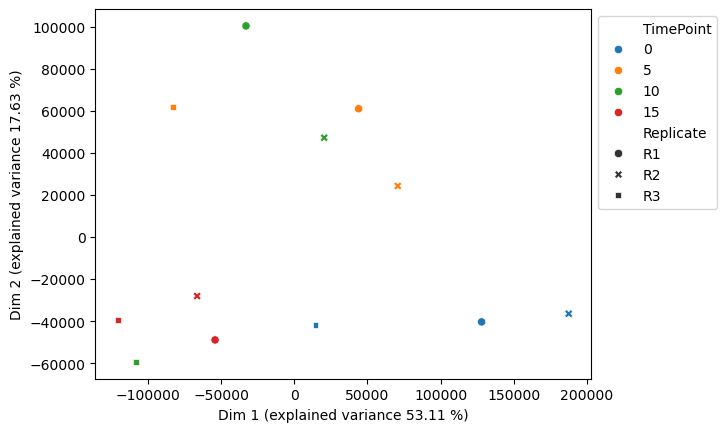

In [21]:
txPCA(tpms[columnOrder])

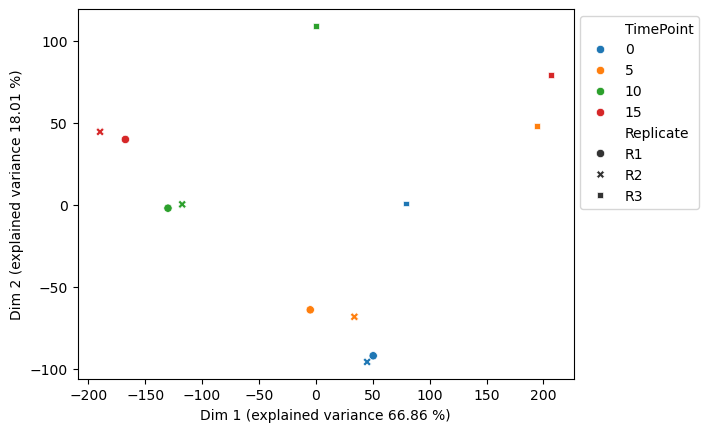

In [22]:
txPCA(logs[columnOrder])

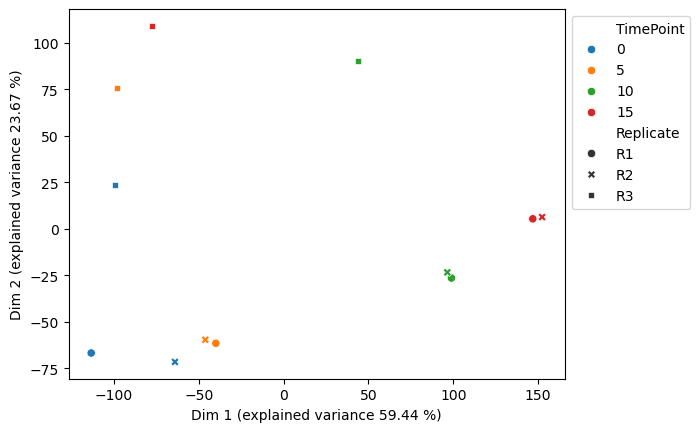

In [23]:
txPCA(logTPMs[columnOrder])

In [24]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

In [25]:
logTPMs

SampleNames,0_R1,0_R2,0_R3,5_R1,5_R2,5_R3,10_R1,10_R2,10_R3,15_R1,15_R2,15_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-PA4267,10.858448,10.813139,10.572976,10.363680,10.972414,10.553649,8.837893,9.307030,11.443338,8.232190,7.767502,6.300340,host,rpsG
gene-PA5105,4.068723,2.465649,3.504347,2.383890,2.633039,4.563145,1.700814,0.889712,1.613967,0.598518,0.888875,4.907817,host,hutC
gene-PA4344,3.385422,2.409136,10.373804,1.755262,2.283081,3.762443,0.652212,0.745193,1.443379,0.529992,0.744459,4.131167,host,gene-PA4344
gene-PA5135,4.249630,3.059187,3.515153,2.926683,2.978070,4.347702,0.927268,1.047341,2.657038,0.378652,0.438425,4.397435,host,gene-PA5135
gene-PA0677,1.771556,1.291051,1.951862,0.281160,1.067226,3.636259,0.208261,0.514683,1.358454,0.164286,0.777002,3.897880,host,gene-PA0677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA4588,5.553041,5.269445,5.084473,3.775997,4.255162,4.810928,1.440321,1.440464,3.931616,0.809278,0.564951,4.664948,host,gdhA
gene-PA3396,1.958388,2.093490,1.509311,1.937226,2.916081,3.918579,1.201393,1.134770,2.295682,1.200223,1.133778,4.374960,host,nosL
gene-PA0901,6.769329,6.337567,5.608545,6.179709,6.882111,4.945697,4.267776,4.704288,4.248041,3.613409,3.043585,3.865749,host,aruE


tpmHost

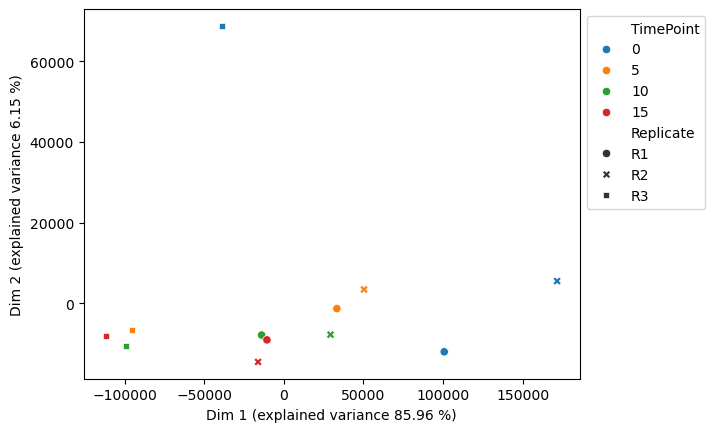

In [26]:
txPCA(tpmHost[columnOrder])

tpmPhage

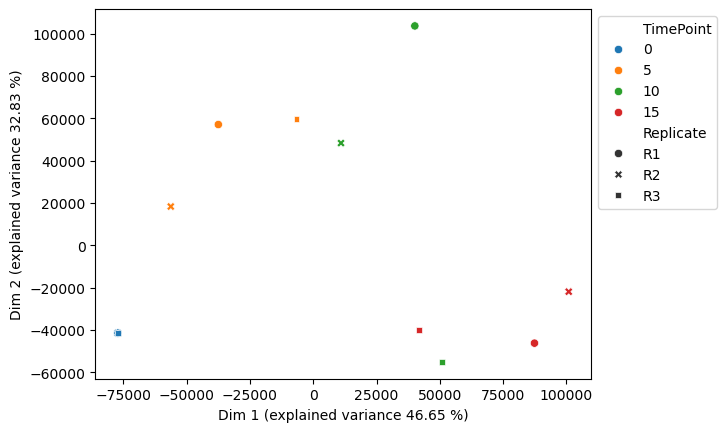

In [27]:
txPCA(tpmPhage[columnOrder])

logTPM Host

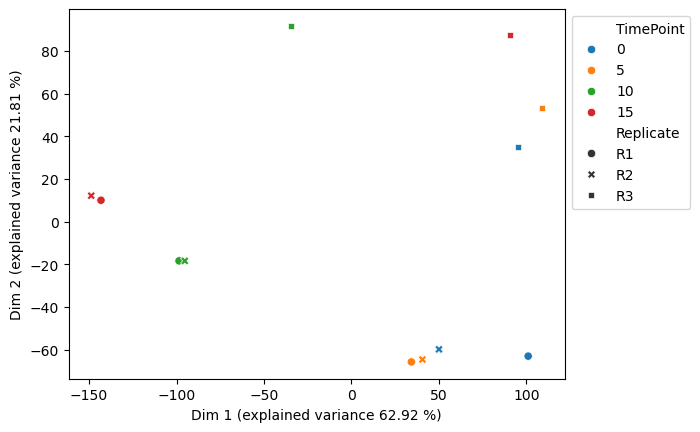

In [28]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

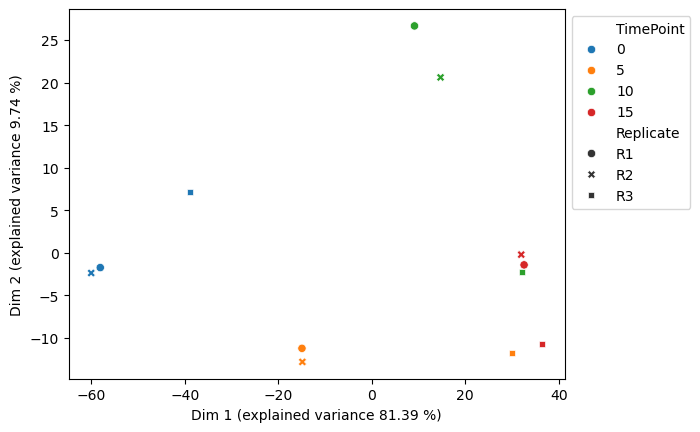

In [29]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ R3 in generall looks very off. I would suggest to remove each R3 in all timepoints, so that two replicates are left for each timepoint.

In [30]:
# Update all dataframes by removing 4_R1
updatedOrder = ['0_R1', '0_R2', '5_R1', '5_R2', '10_R1', '10_R2', '15_R1', '15_R2']
logsUpdated = logs.drop(columns=['0_R3', '5_R3', '10_R3', '15_R3'])
tpmsUpdated = tpms.drop(columns=['0_R3', '5_R3', '10_R3', '15_R3'])

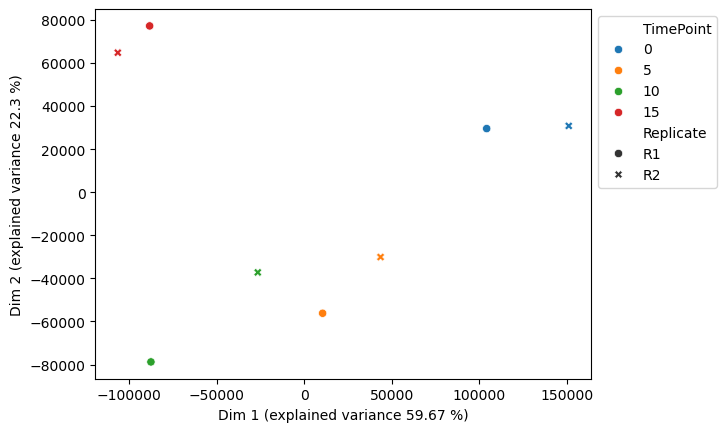

In [31]:
txPCA(tpms[updatedOrder])

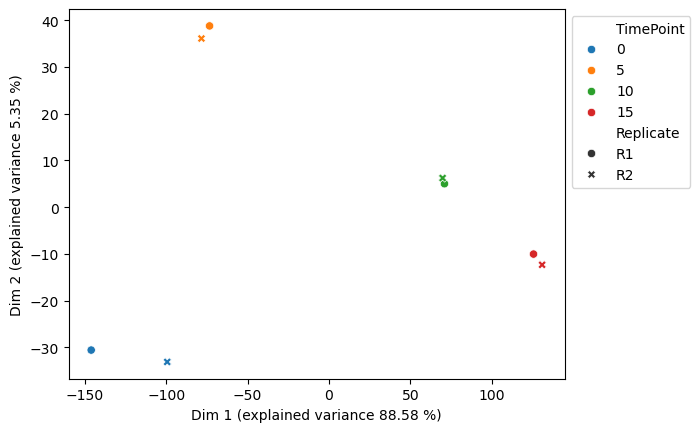

In [32]:
txPCA(logTPMs[updatedOrder])

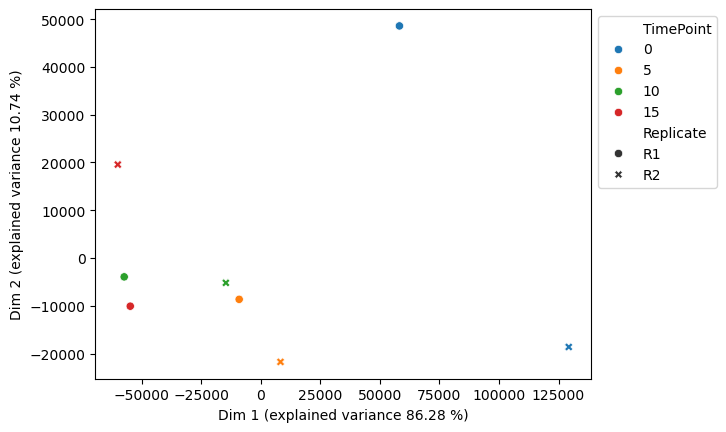

In [33]:
txPCA(tpmHost[updatedOrder])

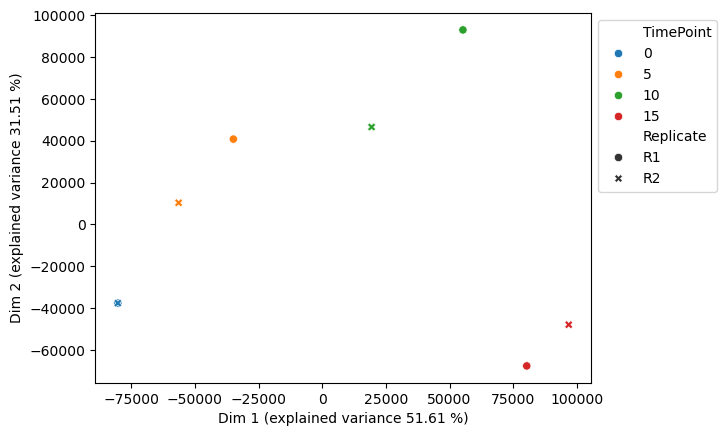

In [34]:
txPCA(tpmPhage[updatedOrder])

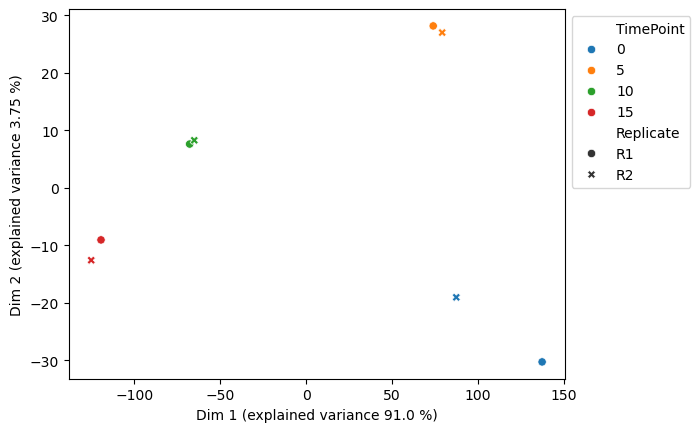

In [35]:
txPCA(logTPMsHost[updatedOrder])

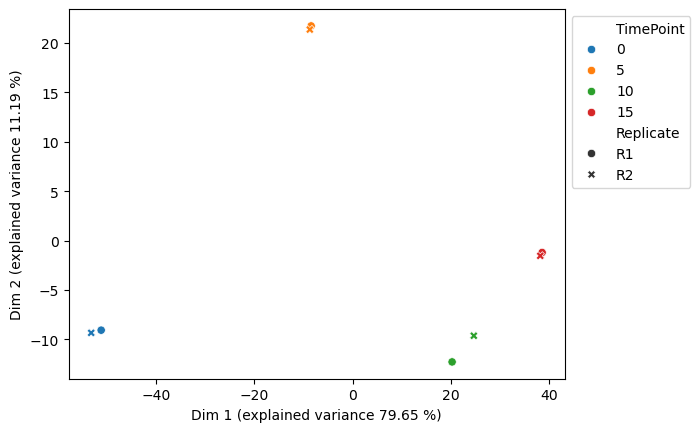

In [36]:
txPCA(logTPMsPhage[updatedOrder])

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

Remove R3 from all timepoint

In [37]:
tpms[updatedOrder].head(2)

SampleNames,0_R1,0_R2,5_R1,5_R2,10_R1,10_R2,15_R1,15_R2
Geneid,,,,,,,,
gene-PA4267,1855.601166,1798.198772,1316.584378,2008.212172,456.583954,632.424857,299.701806,216.896902
gene-PA5105,15.780604,4.523754,4.219421,5.203311,2.250844,0.852807,0.514160,0.851731


In [38]:
tpmsUpdated.head(2)

SampleNames,0_R1,0_R2,5_R1,5_R2,10_R1,10_R2,15_R1,15_R2,Entity,Symbol
Geneid,,,,,,,,,,
gene-PA4267,1855.601166,1798.198772,1316.584378,2008.212172,456.583954,632.424857,299.701806,216.896902,host,rpsG
gene-PA5105,15.780604,4.523754,4.219421,5.203311,2.250844,0.852807,0.514160,0.851731,host,hutC


In [39]:
TPMmeans, TPMsds = getMeanSD(tpms[updatedOrder])
TPMmeans = TPMmeans[['0', '5', '10', '15']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,0,5,10,15,Entity,Symbol
Geneid,,,,,,
gene-PA4267,1826.899969,1662.398275,544.504405,258.299354,host,rpsG
gene-PA5105,10.152179,4.711366,1.551825,0.682946,host,hutC
gene-PA4344,6.880746,3.121519,0.623887,0.559634,host,gene-PA4344
gene-PA5135,12.678733,6.741457,0.984194,0.327625,host,gene-PA5135
gene-PA0677,1.930642,0.655286,0.291988,0.417089,host,gene-PA0677
...,...,...,...,...,...,...
gene-PA4588,41.760298,15.397253,1.713947,0.615836,host,gdhA
gene-PA3396,3.077034,4.688808,1.247726,1.246040,host,nosL
gene-PA0901,93.979213,94.223236,21.666325,9.242168,host,aruE


In [40]:
TPMsds = TPMsds[['0', '5', '10', '15']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,0,5,10,15,Entity,Symbol
Geneid,,,,,,
gene-PA4267,28.701197,345.813897,87.920451,41.402452,host,rpsG
gene-PA5105,5.628425,0.491945,0.699019,0.168785,host,hutC
gene-PA4344,2.569185,0.745643,0.052312,0.115712,host,gene-PA4344
gene-PA5135,5.343706,0.137857,0.082522,0.027499,host,gene-PA5135
gene-PA0677,0.483579,0.440115,0.136693,0.296477,host,gene-PA0677
...,...,...,...,...,...,...
gene-PA4588,4.189288,2.698269,0.000135,0.136498,host,gdhA
gene-PA3396,0.190759,1.859121,0.051891,0.051713,host,nosL
gene-PA0901,14.107311,22.733276,3.403119,1.996791,host,aruE


In [41]:
propExp = proportionalExp(TPMmeans[['0', '5', '10', '15']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,0,5,10,15,Entity,Symbol
Geneid,,,,,,
gene-PA4267,1.000000,0.909956,0.298048,0.141387,host,rpsG
gene-PA5105,1.000000,0.464074,0.152856,0.067271,host,hutC
gene-PA4344,1.000000,0.453660,0.090671,0.081333,host,gene-PA4344
gene-PA5135,1.000000,0.531714,0.077626,0.025841,host,gene-PA5135
gene-PA0677,1.000000,0.339414,0.151239,0.216036,host,gene-PA0677
...,...,...,...,...,...,...
gene-PA4588,1.000000,0.368706,0.041042,0.014747,host,gdhA
gene-PA3396,0.656251,1.000000,0.266107,0.265748,host,nosL
gene-PA0901,0.997410,1.000000,0.229947,0.098088,host,aruE


## 5. Phage gene classification

In [42]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('middle')
        elif timePoint == 3:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [43]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('middle')
        elif timePoint == 3:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [44]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [45]:
TPMmeans

,0,5,10,15,Entity,Symbol,ClassThreshold,ClassMax
Geneid,,,,,,,,
gene-PA4267,1826.899969,1662.398275,544.504405,258.299354,host,rpsG,None,None
gene-PA5105,10.152179,4.711366,1.551825,0.682946,host,hutC,None,None
gene-PA4344,6.880746,3.121519,0.623887,0.559634,host,gene-PA4344,None,None
gene-PA5135,12.678733,6.741457,0.984194,0.327625,host,gene-PA5135,None,None
gene-PA0677,1.930642,0.655286,0.291988,0.417089,host,gene-PA0677,None,None
...,...,...,...,...,...,...,...,...
gene-PA4588,41.760298,15.397253,1.713947,0.615836,host,gdhA,None,None
gene-PA3396,3.077034,4.688808,1.247726,1.246040,host,nosL,None,None
gene-PA0901,93.979213,94.223236,21.666325,9.242168,host,aruE,None,None


In [46]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassMax'].value_counts()

ClassMax
late      33
middle    18
early      3
Name: count, dtype: int64

Add classes to other dfs.

In [47]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpmsUpdated[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
logsUpdated[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[gff3_final['seq_id'] == 'NC_002516.2']
gff3_phage = gff3_final[gff3_final['seq_id'] == 'NC_010326.1']
gff3_genes["seq_id"].unique()

array(['NC_002516.2', 'NC_010326.1'], dtype=object)

## 6. Add variance to all dataframes

Base variance call on tpms.

In [48]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [49]:
tpmsUpdated = stabilizedVariance(tpmsUpdated)
tpmsUpdated

SampleNames,0_R1,0_R2,5_R1,5_R2,10_R1,10_R2,15_R1,15_R2,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,
gene-PA4267,1855.601166,1798.198772,1316.584378,2008.212172,456.583954,632.424857,299.701806,216.896902,host,rpsG,None,None,463.329017
gene-PA5105,15.780604,4.523754,4.219421,5.203311,2.250844,0.852807,0.514160,0.851731,host,hutC,None,None,5.116789
gene-PA4344,9.449931,4.311561,2.375875,3.867162,0.571576,0.676199,0.443921,0.675346,host,gene-PA4344,None,None,3.011263
gene-PA5135,18.022439,7.335028,6.603600,6.879313,0.901672,1.066717,0.300126,0.355124,host,gene-PA5135,None,None,6.193379
gene-PA0677,2.414221,1.447063,0.215172,1.095401,0.155295,0.428681,0.120611,0.713566,host,gene-PA0677,None,None,0.678563
...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA4588,45.949586,37.571010,12.698985,18.095522,1.713812,1.714081,0.752334,0.479337,host,gdhA,None,None,18.902822
gene-PA3396,2.886275,3.267794,2.829687,6.547929,1.299616,1.195835,1.297752,1.194327,host,nosL,None,None,1.144848
gene-PA0901,108.086524,79.871902,71.489960,116.956511,18.263206,25.069444,11.238960,7.245377,host,aruE,None,None,31.919643


In [50]:
logsUpdated['Variance'] = tpmsUpdated['Variance']
TPMmeans['Variance'] = tpmsUpdated['Variance']
TPMsds['Variance'] = tpmsUpdated['Variance']
propExp['Variance'] = tpmsUpdated['Variance']

## 7. Write data to output

In [51]:
df_norRNAs = df_norRNAs.drop(columns=['0_R3', '5_R3', '10_R3', '15_R3'])
df_norRNAs[['Entity', 'Symbol']] = tpmsUpdated[['Entity', 'Symbol']]
df_norRNAs

SampleNames,0_R1,0_R2,5_R1,5_R2,10_R1,10_R2,15_R1,15_R2,Entity,Symbol
Geneid,,,,,,,,,,
gene-PA4267,2537,4102,2244,4707,1078,1623,911,557,host,rpsG
gene-PA5105,34,16,11,19,8,3,2,3,host,hutC
gene-PA4344,33,25,10,23,3,4,3,4,host,gene-PA4344
gene-PA5135,40,27,18,26,3,4,1,1,host,gene-PA5135
gene-PA0677,4,4,0,3,0,1,0,2,host,gene-PA0677
...,...,...,...,...,...,...,...,...,...,...
gene-PA4588,178,243,61,120,11,12,6,3,host,gdhA
gene-PA3396,4,8,5,17,3,3,4,3,host,nosL
gene-PA0901,313,386,258,581,91,136,72,39,host,aruE


In [52]:
# Full TPM table
tpmsUpdated.to_csv('Brandao_MCCM_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAs.to_csv('Brandao_MCCM_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Brandao_MCCM_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Brandao_MCCM_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Brandao_MCCM_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('Brandao_MCCM_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('Brandao_MCCM_phage_gff3.tsv', sep='\t')